[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/sachdevkartik/GSoC-2022/blob/main/test2_DistillableViT.ipynb)


# __Classifying Dark Matter Substructure using Distillable Visual Transformer__

This approach uses Hugo Touvron et al., <b> Training data-efficient image transformers & distillation through attention </b>, it used a teacher-student strategy specific to transformers. It relies on a distillation token ensuring that the student learns from the teacher through attention. Here, for our case, I have used the pretrained [EquivariantNetwork](model/ConvTransformer_2022-03-15-13-40-54.pt) from [Task 1](test1.ipynb) as teacher and a lightweight **distillable transformer network** as a student. 

<p>
The primary inituition behind the selection of a pretrained Equivariant network is that the network already has a good representation of Dark Matter Substructure from Task 1. The E2-CNNs architecture are used as they are equivariant under all isometries E(2) of the image plane i.e. under translations, rotations and reflections. The reason for selecting transformers is that they have good generalization ability and can attend to desired patterns in the image. In this way, we can induce biases of symetries in a transformer model by using an equivariance convolutional model as teacher.
</p>

<p>
So, with this scheme in mind, the presented approach tries to teach the transformer to learn representation that are equivariant to <b>4 rotations</b> from the teacher. This resulted in a lightweight Vision transformer with only <b>0.15M parameters</b> with a <b>batch size of 128</b> and a training time of approx <b>2 hours</b> on <b>RTX 2070 8 GB</b> (laptop version) with the given dataset. The experiment opens up the door towards building lighter and faster models for the task in hand. 
</p>

<p>
One possible <b>future direction</b> would be to use <b>multiple teacher networks</b> to include <b>more symmetries and reflections</b> which are learnt by the trained Equivariant networks already available in the database. In this way the student (transformer) could learn a variety of intrinsic properties of the data efficiently.
</p>

## __Results__

| S.No | Metric | Value |
| --- | --- | --- |
| 1. | Best validation accuracy | 77.15% |
| 2. | AUC (with sub structure)  | 0.8807 |
| 3. | AUC (without sub structure)  | 0.8734 |

# __Google colab__
To run in Google colab, please execute the below cell for installing the requisite dependencies. The cell also clone the solution repo as it contains files for execution. 

In [1]:
!pip install  split-folders \
              torchinfo \
              einops \
              e2cnn \
              vit-pytorch
!pip install --upgrade --no-cache-dir gdown

In [ ]:
# run in the case of Colab only
%%bash
set -m
git clone https://github.com/sachdevkartik/GSoC-2022.git
mv GSoC-2022/* . 
rm -rf GSoC-2022

# __Running Locally__
To run locally, please execute the below cell for installing CUDA, pytorch among other dependencies and set up the conda env. If some of the dependcies are already installed like pytorch or cuda, please cherrypick dependencis from the ```setup.bash``` file

In [ ]:
# %%bash
# bash setup.bash

# __Essential imports__

In [2]:
from __future__ import print_function

import glob
from itertools import chain
import os
from os import listdir
from os.path import join
import random
import zipfile
import logging
import time
import copy
import gdown

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from PIL import Image
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau, CosineAnnealingWarmRestarts
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from torchvision.transforms import (RandomRotation, RandomCrop,
                                    Pad, Resize, RandomAffine,
                                    ToTensor, Compose, RandomPerspective)
from tqdm.notebook import tqdm
import splitfolders
from sklearn.metrics import roc_curve, auc, confusion_matrix

from torchvision.models import resnet50, resnet18
from vit_pytorch.efficient import ViT
from vit_pytorch.distill import DistillableViT, DistillWrapper
from equivariance_net import Equivariant_Network
from torchinfo import summary


## __Make required folders for data and models__

In [3]:
# check if the directory for data exists else make it
os.makedirs('data', exist_ok=True)
os.makedirs("model", exist_ok=True)

## __Download data__
A set of simulated strong gravitational lensing images with and without substructure. 

| S.No | Classes | # Images |
| --- | --- | --- |
| 1. | With substructure | 5000 |
| 2. | Without substructure | 5000 |

In [4]:
# check if the compressed data file from gdrive exist 
# else download in the directory
if not os.path.isfile('data/lenses.tgz'):
    url = "https://drive.google.com/uc?id=16Y1taQoTeUTP5rGpB0tuPZ_S30acvnqr"
    output = "data/lenses.tgz"
    gdown.download(url, output, quiet=False)
else:
    print("File exists")

File exists


## __Extract data__
Check if the compressed data file is already extracted else extract data, and create the train-test split (0.9:0.1). <br>

The data folder looks like: 

```bash
lenses
├── train
│   ├── no_sub
│   └── sub
└── val
    ├── no_sub
    └── sub
```

In [5]:
# initialize the data directory name  
data_dir = 'data/lenses'

if os.path.isdir(data_dir):
    print("Extracted folder exists")
else:
    print("Extracting folder")
    os.system('tar xf data/lenses.tgz --directory data ; mv data/lenses data/lenses_raw')
    splitfolders.ratio('data/lenses_raw', output="data/lenses", seed=1337, ratio=(.9, 0.1))
    os.system('rm -r data/lenses_raw') 

Extracted folder exists


In [6]:
print(f"Torch: {torch.__version__}")

Torch: 1.6.0


## __Set Config and Hyperparameters__

In [7]:
# Data setting
n_classes = 2               # number of classes to be classified
img_size = 224              # image size (224x224)

# Training parameters
batch_size = 128            # batch size
epochs = 50                 # number of epochs
lr = 0.001                  # Initial learning rate

# optimizer parameters
weight_decay = 0            # L2 penalty
amsgrad = True              # Use AMSGrad with Adam or not 
gamma = 0.5                 # factor by which to decrease learnin
step_size_opt = 15          # interval to apply optimizer schedul
use_lr_schedule = True      # To apply LR scheduler or not

seed = 42                   # fixing seed for repeatability
use_cuda = True             # Using CUDA
cuda_idx = 0                # idx of CUDA device to be used

data_dir = 'data/lenses'

In [8]:
def seed_everything(seed):
    """Fixing various seeds

    Args:
        seed (int): any seed number

    """
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(seed)

## __Select CUDA device for training__

In [9]:
def get_device(use_cuda=True, cuda_idx=0):
    """Get the CUDA device

    Args:
        use_cuda (Bool): To used CUDA or not
        cuda_idx (int): index of CUDA device 
    
    Returns:
        device: CUDA device(s) being used 
    """

    if use_cuda:
        if torch.cuda.is_available():
            assert cuda_idx in range(0, torch.cuda.device_count()),\
                "GPU index out of range. index lies in [{}, {})".format(0, torch.cuda.device_count())
            device = torch.device("cuda:"+str(cuda_idx))
        else:
            print("cuda not found, will switch to cpu")
    else:
        device = torch.device("cpu")
    print(f'Using device = {str(device)}')
    return device

In [10]:
device = get_device(use_cuda, cuda_idx)

Using device = cuda:0


## __Logger to save the results__

In [11]:
def init_logging_handler(log_dir, current_time, extra=''):
    """Initializes the handler for logger. Create the logger directory if it doest exists. 
        Define the format of logging
        DEBUG logging level being used

    Args:
        log_dir (str): Logger directory
        current_time (str): time from logging to begin  
        extra (str): Space for adding extra info in .txt file
    
    """
    
    if not os.path.exists(log_dir):
        os.makedirs(log_dir)

    if not os.path.exists(os.path.join(log_dir, current_time)):
        os.makedirs(os.path.join(log_dir, current_time))

    stderr_handler = logging.StreamHandler()
    file_handler = logging.FileHandler('{}/{}/log_{}.txt'.format(
        log_dir, current_time, current_time + extra))
    logging.basicConfig(handlers=[stderr_handler, file_handler])
    logger = logging.getLogger()
    logger.setLevel(logging.DEBUG)
    
logging.getLogger('matplotlib.font_manager').disabled = True

In [12]:
current_time = time.strftime("%Y-%m-%d-%H-%M-%S", time.localtime())
log_dir = 'logger'
init_logging_handler(log_dir, current_time)

## __Set the path for saving trained model name__

In [13]:
os.makedirs("model", exist_ok=True)
PATH = os.path.join("model", f"DistillableViT_{current_time}.pt")

## __Load Data__

In [14]:
os.makedirs('data', exist_ok=True)

## __Transformations__ 

Transformations are kept similar as Task 1 because the teacher network was trained on it. Following transformations are performed on the dataset:

1. Randomly crop to $128 \times 128$ 
2. Padded to increase to $129 \times 129$
3. Resized to $387 \times 387$
4. Randomly rotate between 0 $^{\circ}$ -180 $^{\circ}$ 
7. Resized to $129 \times 129$.
8. Converting to grayscale
9. Converting PIL image to tensor

Transformation were refered from Task 1 with equivariant networks.

In [15]:
# images are padded to have shape 129x129.
# this allows to use odd-size filters with stride 2 when downsampling a feature map in the model
pad = Pad((0, 0, 1, 1), fill=0)
# to reduce interpolation artifacts (e.g. when testing the model on rotated images),
# we upsample an image by a factor of 3, rotate it and finally downsample it again
resize1 = Resize(387)
resize2 = Resize(129)
totensor = ToTensor()
togray = transforms.Grayscale(num_output_channels=1)
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

In [16]:
transform_train = transforms.Compose([
    transforms.RandomCrop(128),
    pad,
    resize1,
    RandomRotation(degrees=(0, 180), resample=Image.BILINEAR, expand=False),
    resize2,
    togray,
    totensor,
])
transform_test = transforms.Compose([
    transforms.RandomCrop(128),
    pad,
    togray,
    totensor,
])

## __Defining custom dataset for given data__

In [17]:
class CustomDataset(Dataset):
    """Create custom dataset for the given data

    """

    def __init__(self, root_dir, mode, transform=None):
        assert mode in ['train', 'test', 'val']

        self.root_dir = root_dir

        if mode == "train":
            self.root_dir = self.root_dir+"/train"
        elif mode == "test":
            self.root_dir = self.root_dir+"/test"
        else:
            self.root_dir = self.root_dir+"/val"

        self.transform = transform
        classes = listdir(self.root_dir)
        classes.sort()
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
        self.imagefilename = []
        self.labels = []
        
        for i in classes:
            for x in listdir(join(self.root_dir, i)):
                self.imagefilename.append(join(self.root_dir, i,x))
                self.labels.append(self.class_to_idx[i])

    
    def __getitem__(self, index):
        image, label = self.imagefilename[index], self.labels[index]
        
        image = Image.open(image)
        if self.transform is not None:
            image = self.transform(image)
        return image, label
    
    def __len__(self):
        return len(self.labels)

In [18]:
trainset = CustomDataset(data_dir,'train',transform=transform_train)
valset = CustomDataset(data_dir,'val',transform=transform_test)
print(trainset[12][0].size())

torch.Size([1, 129, 129])


## __Dataloader__
Loading train and test data with shuffle and given batch size

In [19]:
train_loader = DataLoader(dataset = trainset, batch_size=batch_size, shuffle=True )
valid_loader = DataLoader(dataset = valset, batch_size=batch_size, shuffle=True)

## __Visualize image samples__

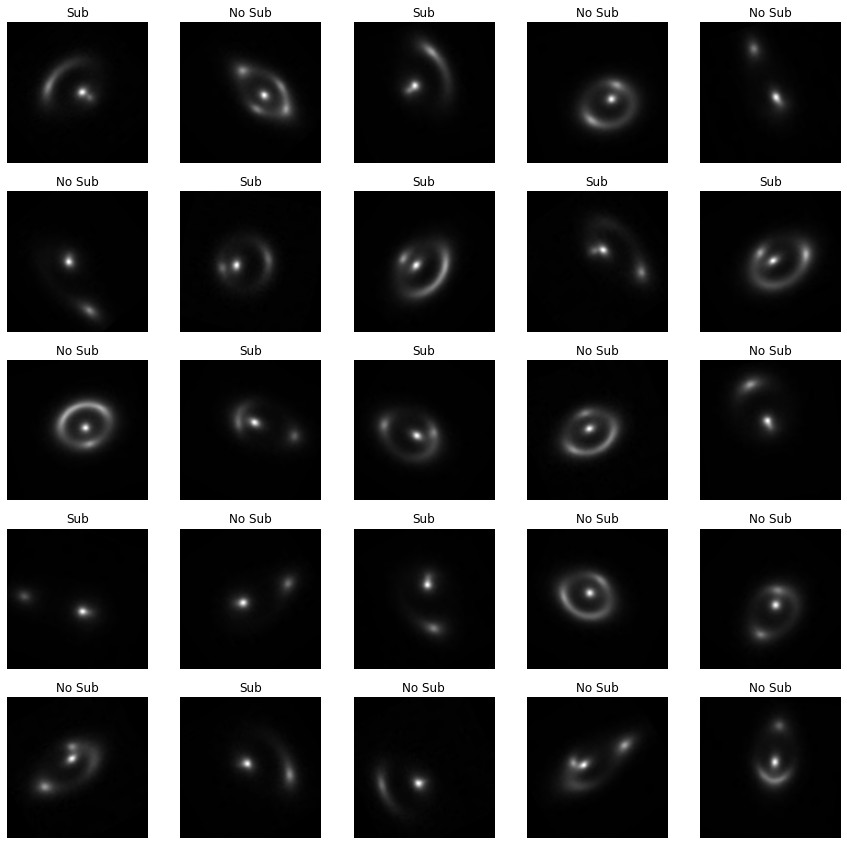

In [20]:
labels_map = {0: 'No Sub',1:'Sub'}
figure = plt.figure(figsize=(15, 15))
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(trainset), size=(1,)).item()
    img, label = trainset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    # im = transforms.ToPILImage()(img)
    im = img.squeeze()
    plt.imshow(im, cmap='gray')
plt.show()

In [21]:
print(f"Train Data: {len(trainset)}")
print(f"Val Data: {len(valset)}")

Train Data: 9000
Val Data: 1000


## __Distillable Vision Transformer__

### **Teacher**
Basically, we would want to fine-tune the teacher network to this dataset. <br> Following steps were used:

1. Load the pretrained Equivaraint network from Task 1
2. Change the last fully connected layers to adapt to this dataset 
3. Change the num of classes from 3 to 2
4. Fix the backbone network and only train the fully connected layers


In [22]:
teacher = Equivariant_Network(n_classes=3, sym_group = 'Circular', N = 4)

TEACHER_PATH = 'model/cnn_state_dict_model.pt'
teacher.load_state_dict(torch.load(TEACHER_PATH))
for param in teacher.parameters():
    param.requires_grad = False   

# Fully Connected
teacher.fully_net = torch.nn.Sequential(
    torch.nn.Linear(43264, 32),
    torch.nn.BatchNorm1d(32),
    torch.nn.ELU(inplace=True),
    torch.nn.Linear(32, n_classes),
).to(device)


##### in_type: ##### [4-Rotations: {irrep_0}]


### **Student**
Create a distillable Vision transformer with the following data:

In [23]:
v = DistillableViT(
    image_size=129,
    patch_size=43,
    num_classes=2,
    dim = 32,
    channels=1,
    depth = 1,
    heads = 3,
    mlp_dim = 1024,
).to(device)

distiller = DistillWrapper(
    student = v,
    teacher = teacher,
    temperature = 6,           # temperature of distillation
    alpha = 0.5,               # trade between main loss and distillation loss
    hard = False               # whether to use soft or hard distillation
).to(device)

summary(v, input_size=(batch_size, 1, 129, 129))


Layer (type:depth-idx)                             Output Shape              Param #
DistillableViT                                     --                        --
├─Transformer: 1                                   --                        --
│    └─ModuleList: 2-1                             --                        --
│    │    └─ModuleList: 3-1                        --                        91,328
├─Sequential: 1-1                                  [128, 9, 32]              --
│    └─Rearrange: 2-2                              [128, 9, 1849]            --
│    └─Linear: 2-3                                 [128, 9, 32]              59,200
├─Dropout: 1-2                                     [128, 10, 32]             --
├─Transformer: 1-3                                 [128, 10, 32]             --
├─Identity: 1-4                                    [128, 32]                 --
├─Sequential: 1-5                                  [128, 2]                  --
│    └─LayerNorm: 2-4      

## __Training__

In [24]:
# loss function
criterion = nn.CrossEntropyLoss()
# optimizer
optimizer = optim.Adam(v.parameters(), lr=lr, betas=(0.9, 0.999), weight_decay=weight_decay, amsgrad=amsgrad)
# scheduler
scheduler_plateau = ReduceLROnPlateau(optimizer, 'min', factor=0.1, patience=4, threshold=0.0000001, verbose=True)
scheduler_step = StepLR(optimizer, step_size=step_size_opt, gamma=gamma)
scheduler_step_cosine = CosineAnnealingWarmRestarts(optimizer, T_0=3, T_mult=2, eta_min=0.0005, last_epoch=-1)


In [25]:
all_train_loss = []
all_val_loss = []
all_train_accuracy = []
all_val_accuracy = []
lrs = []

best_accuracy = 0

for epoch in range(epochs):
    epoch_loss = 0
    epoch_accuracy = 0
    tr_loss_epoch = []
    running_loss = 0


    for data, label in tqdm(train_loader):
        data = data.to(device)
        label = label.to(device)

        # output = v(data)
        loss = distiller(data, label)
        epoch_loss += loss.item() 

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
        # running_loss += loss.item() * data.size(0) # epoch_loss = running_loss / dataset_sizes[phase]
    epoch_loss = epoch_loss / len(train_loader)
    # all_train_loss.append(np.asarray(tr_loss_epoch))

    with torch.no_grad():
        epoch_val_accuracy = 0
        epoch_val_loss = 0
        for data, label in valid_loader:
            data = data.to(device)
            label = label.to(device)

            val_output = v(data)
            val_loss = distiller(data, label)

            acc = (val_output.argmax(dim=1) == label).float().mean()
            epoch_val_accuracy += acc 
            epoch_val_loss += val_loss 
        epoch_val_accuracy =epoch_val_accuracy / len(valid_loader)
        epoch_val_loss =epoch_val_loss / len(valid_loader)
    
    all_val_loss.append(np.asarray(epoch_val_loss.item()))
    all_val_accuracy.append(epoch_val_accuracy.item()*100)
    logging.debug(        
        f"Epoch : {epoch+1} - LR {optimizer.param_groups[0]['lr']:.8f} - loss : {epoch_loss:.4f} - val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f}\n"
    )

    if use_lr_schedule:
        # scheduler_plateau.step(epoch_loss) # ReduceLROnPlateau
        scheduler_step.step() # StepLR

    lrs.append(
        optimizer.param_groups[0]["lr"]
    )

    
    if epoch_val_accuracy > best_accuracy:
        best_accuracy = epoch_val_accuracy
        best_model = copy.deepcopy(v)  
        torch.save(best_model.state_dict(), PATH)

DEBUG:root:Epoch : 1 - LR 0.00100000 - loss : 0.3798 - val_loss : 0.3686 - val_acc: 0.5007



DEBUG:root:Epoch : 2 - LR 0.00100000 - loss : 0.3692 - val_loss : 0.3661 - val_acc: 0.5349



DEBUG:root:Epoch : 3 - LR 0.00100000 - loss : 0.3684 - val_loss : 0.3664 - val_acc: 0.5505



DEBUG:root:Epoch : 4 - LR 0.00100000 - loss : 0.3665 - val_loss : 0.3693 - val_acc: 0.5166



DEBUG:root:Epoch : 5 - LR 0.00100000 - loss : 0.3640 - val_loss : 0.3758 - val_acc: 0.4993



DEBUG:root:Epoch : 6 - LR 0.00100000 - loss : 0.3628 - val_loss : 0.3617 - val_acc: 0.5527



DEBUG:root:Epoch : 7 - LR 0.00100000 - loss : 0.3561 - val_loss : 0.3448 - val_acc: 0.6208



DEBUG:root:Epoch : 8 - LR 0.00100000 - loss : 0.3519 - val_loss : 0.3425 - val_acc: 0.6144



DEBUG:root:Epoch : 9 - LR 0.00100000 - loss : 0.3423 - val_loss : 0.3437 - val_acc: 0.5808



DEBUG:root:Epoch : 10 - LR 0.00100000 - loss : 0.3387 - val_loss : 0.3357 - val_acc: 0.6021



DEBUG:root:Epoch : 11 - LR 0.00100000 - loss : 0.3252 - val_loss : 0.3193 - val_acc: 0.6456



DEBUG:root:Epoch : 12 - LR 0.00100000 - loss : 0.3197 - val_loss : 0.3155 - val_acc: 0.6666



DEBUG:root:Epoch : 13 - LR 0.00100000 - loss : 0.3197 - val_loss : 0.2998 - val_acc: 0.7013



DEBUG:root:Epoch : 14 - LR 0.00100000 - loss : 0.3055 - val_loss : 0.2978 - val_acc: 0.6678



DEBUG:root:Epoch : 15 - LR 0.00100000 - loss : 0.3056 - val_loss : 0.2912 - val_acc: 0.6976



DEBUG:root:Epoch : 16 - LR 0.00050000 - loss : 0.2814 - val_loss : 0.2716 - val_acc: 0.7148



DEBUG:root:Epoch : 17 - LR 0.00050000 - loss : 0.2826 - val_loss : 0.2717 - val_acc: 0.7037



DEBUG:root:Epoch : 18 - LR 0.00050000 - loss : 0.2792 - val_loss : 0.2653 - val_acc: 0.7093



DEBUG:root:Epoch : 19 - LR 0.00050000 - loss : 0.2714 - val_loss : 0.2703 - val_acc: 0.7142



DEBUG:root:Epoch : 20 - LR 0.00050000 - loss : 0.2776 - val_loss : 0.2781 - val_acc: 0.7227



DEBUG:root:Epoch : 21 - LR 0.00050000 - loss : 0.2696 - val_loss : 0.2606 - val_acc: 0.7236



DEBUG:root:Epoch : 22 - LR 0.00050000 - loss : 0.2684 - val_loss : 0.2446 - val_acc: 0.7618



DEBUG:root:Epoch : 23 - LR 0.00050000 - loss : 0.2633 - val_loss : 0.2457 - val_acc: 0.7529



DEBUG:root:Epoch : 24 - LR 0.00050000 - loss : 0.2677 - val_loss : 0.2498 - val_acc: 0.7291



DEBUG:root:Epoch : 25 - LR 0.00050000 - loss : 0.2627 - val_loss : 0.2606 - val_acc: 0.7349



DEBUG:root:Epoch : 26 - LR 0.00050000 - loss : 0.2556 - val_loss : 0.2412 - val_acc: 0.7521



DEBUG:root:Epoch : 27 - LR 0.00050000 - loss : 0.2646 - val_loss : 0.2355 - val_acc: 0.7649



DEBUG:root:Epoch : 28 - LR 0.00050000 - loss : 0.2568 - val_loss : 0.2775 - val_acc: 0.7302



DEBUG:root:Epoch : 29 - LR 0.00050000 - loss : 0.2575 - val_loss : 0.2447 - val_acc: 0.7326



DEBUG:root:Epoch : 30 - LR 0.00050000 - loss : 0.2556 - val_loss : 0.2374 - val_acc: 0.7649



DEBUG:root:Epoch : 31 - LR 0.00025000 - loss : 0.2504 - val_loss : 0.2491 - val_acc: 0.7371



DEBUG:root:Epoch : 32 - LR 0.00025000 - loss : 0.2457 - val_loss : 0.2375 - val_acc: 0.7668



DEBUG:root:Epoch : 33 - LR 0.00025000 - loss : 0.2462 - val_loss : 0.2375 - val_acc: 0.7396



DEBUG:root:Epoch : 34 - LR 0.00025000 - loss : 0.2478 - val_loss : 0.2322 - val_acc: 0.7498



DEBUG:root:Epoch : 35 - LR 0.00025000 - loss : 0.2446 - val_loss : 0.2351 - val_acc: 0.7338



DEBUG:root:Epoch : 36 - LR 0.00025000 - loss : 0.2432 - val_loss : 0.2345 - val_acc: 0.7378



DEBUG:root:Epoch : 37 - LR 0.00025000 - loss : 0.2415 - val_loss : 0.2375 - val_acc: 0.7495



DEBUG:root:Epoch : 38 - LR 0.00025000 - loss : 0.2382 - val_loss : 0.2429 - val_acc: 0.7397



DEBUG:root:Epoch : 39 - LR 0.00025000 - loss : 0.2405 - val_loss : 0.2339 - val_acc: 0.7534



DEBUG:root:Epoch : 40 - LR 0.00025000 - loss : 0.2430 - val_loss : 0.2294 - val_acc: 0.7573



DEBUG:root:Epoch : 41 - LR 0.00025000 - loss : 0.2442 - val_loss : 0.2506 - val_acc: 0.7426



DEBUG:root:Epoch : 42 - LR 0.00025000 - loss : 0.2475 - val_loss : 0.2318 - val_acc: 0.7770



DEBUG:root:Epoch : 43 - LR 0.00025000 - loss : 0.2369 - val_loss : 0.2294 - val_acc: 0.7429



DEBUG:root:Epoch : 44 - LR 0.00025000 - loss : 0.2437 - val_loss : 0.2289 - val_acc: 0.7705



DEBUG:root:Epoch : 45 - LR 0.00025000 - loss : 0.2387 - val_loss : 0.2317 - val_acc: 0.7690



DEBUG:root:Epoch : 46 - LR 0.00012500 - loss : 0.2348 - val_loss : 0.2279 - val_acc: 0.7715



DEBUG:root:Epoch : 47 - LR 0.00012500 - loss : 0.2310 - val_loss : 0.2230 - val_acc: 0.7574



DEBUG:root:Epoch : 48 - LR 0.00012500 - loss : 0.2358 - val_loss : 0.2270 - val_acc: 0.7592



DEBUG:root:Epoch : 49 - LR 0.00012500 - loss : 0.2320 - val_loss : 0.2372 - val_acc: 0.7459



DEBUG:root:Epoch : 50 - LR 0.00012500 - loss : 0.2341 - val_loss : 0.2312 - val_acc: 0.7556



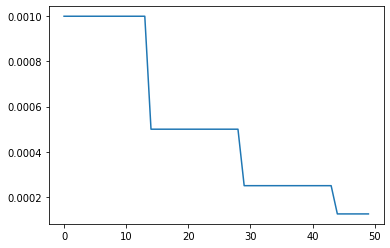

In [26]:
# visualize learning rate change throughout the training
plt.plot(lrs)

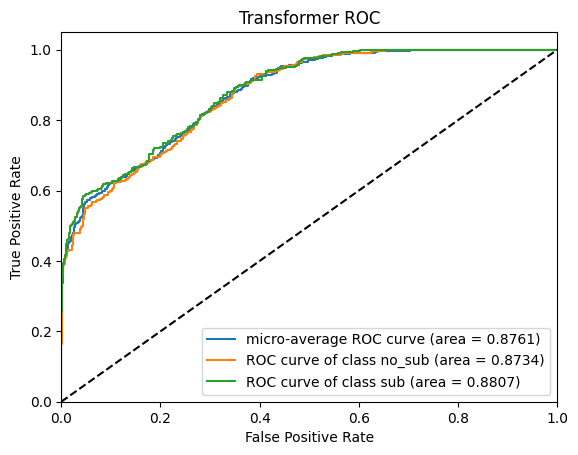

In [27]:
def to_one_hot_vector(num_class, label):
    b = np.zeros((label.shape[0], num_class))
    b[np.arange(label.shape[0]), label] = 1

    return b.astype(int)

plt.rcParams.update(plt.rcParamsDefault)

total = 0
all_test_loss = []
all_test_accuracy = []
label_true_arr = []
label_true_arr_onehot = []
label_pred_arr = []
pred_arr = []

correct = 0
with torch.no_grad():
    best_model.eval()
    for i, (x, t) in enumerate(valid_loader):
        x = x.to(device)
        t = t.to(device)
        y = best_model(x)

        pred_arr.append(y.cpu().numpy())


        _, prediction = torch.max(y.data, 1)
        label_pred_arr.append(prediction.cpu().numpy())
        total += t.shape[0]
        correct += (prediction == t).sum().item()
        label_true_arr.append(t.cpu().numpy())

        one_hot_t = to_one_hot_vector(n_classes,t.cpu().numpy())
        label_true_arr_onehot.append(one_hot_t)

y_pred = []
for i in label_pred_arr:
    for j in i:
        y_pred.append(j)
y_pred = np.array(y_pred)        
        
y_true_onehot = []
for i in label_true_arr_onehot:
    for j in i:
        y_true_onehot.append(list(j))
y_true_onehot = np.array(y_true_onehot)

y_score = []
for i in pred_arr:
    for j in i:
        y_score.append(list(j))
y_score = np.array(y_score)

y_true = []
for i in label_true_arr:
    for j in i:
        y_true.append(j)
y_true = np.array(y_true)

fpr = dict()
tpr = dict()
roc_auc = dict()


for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_onehot[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


inv_map = {v: k for k, v in valset.class_to_idx.items()}



# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_true_onehot.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.4f})'
               ''.format(roc_auc["micro"]))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class '+ inv_map[i]+ ' (area = {0:0.4f})'
                                   ''.format(roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Transformer ROC')
plt.legend(loc="lower right")
plt.show()

In [28]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')


    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f2eefd74340>
DEBUG:matplotlib.colorbar:Using auto colorbar locator on colorbar
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f2eefd74340>
DEBUG:matplotlib.colorbar:Setting pcolormesh


Confusion matrix, without normalization


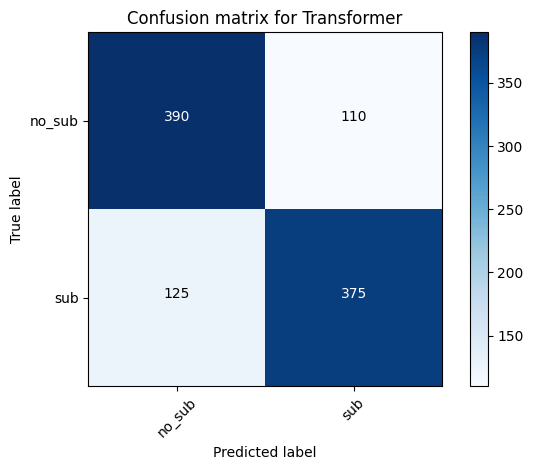

In [29]:
cnf_matrix = confusion_matrix(y_true, y_pred, labels=[0, 1])

np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=[inv_map[0], inv_map[1]],title='Confusion matrix for Transformer')

## __Future work__
Experiment above shows that Distillable Vision Transformer provide lightweight transformer solution which can be effectively trained with a small dataset. However, there are multiple areas of improvement and strategies to be adapted to increase the metrics/results: 
<br>
1. Run hyperparameter tuning using schedulers like Population-based training (PBT) or Hyperband to find better hyperparameters
2. Explore variations and combinations of networks
3. Use Multiple teacher networks to include more symmetries and reflections
4. Lots and lots of data :)

# __Cite__

Inspired from: <br> <br> 
[Training data-efficient image transformers & distillation through attention](https://arxiv.org/pdf/2012.12877.pdf)


  ```
@article{touvron2020deit,
  title={Training data-efficient image transformers & distillation through attention},
  author={Hugo Touvron and Matthieu Cord and Matthijs Douze and Francisco Massa and Alexandre Sablayrolles and Herv\'e J\'egou},
  journal={arXiv preprint arXiv:2012.12877},
  year={2020}
}
  ```

Apoorva Singh, Yurii Halychanskyi, Marcos Tidball, DeepLense, (2021), GitHub repository, https://github.com/ML4SCI/DeepLense

